In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import torch

from defocus import Microscope

from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration

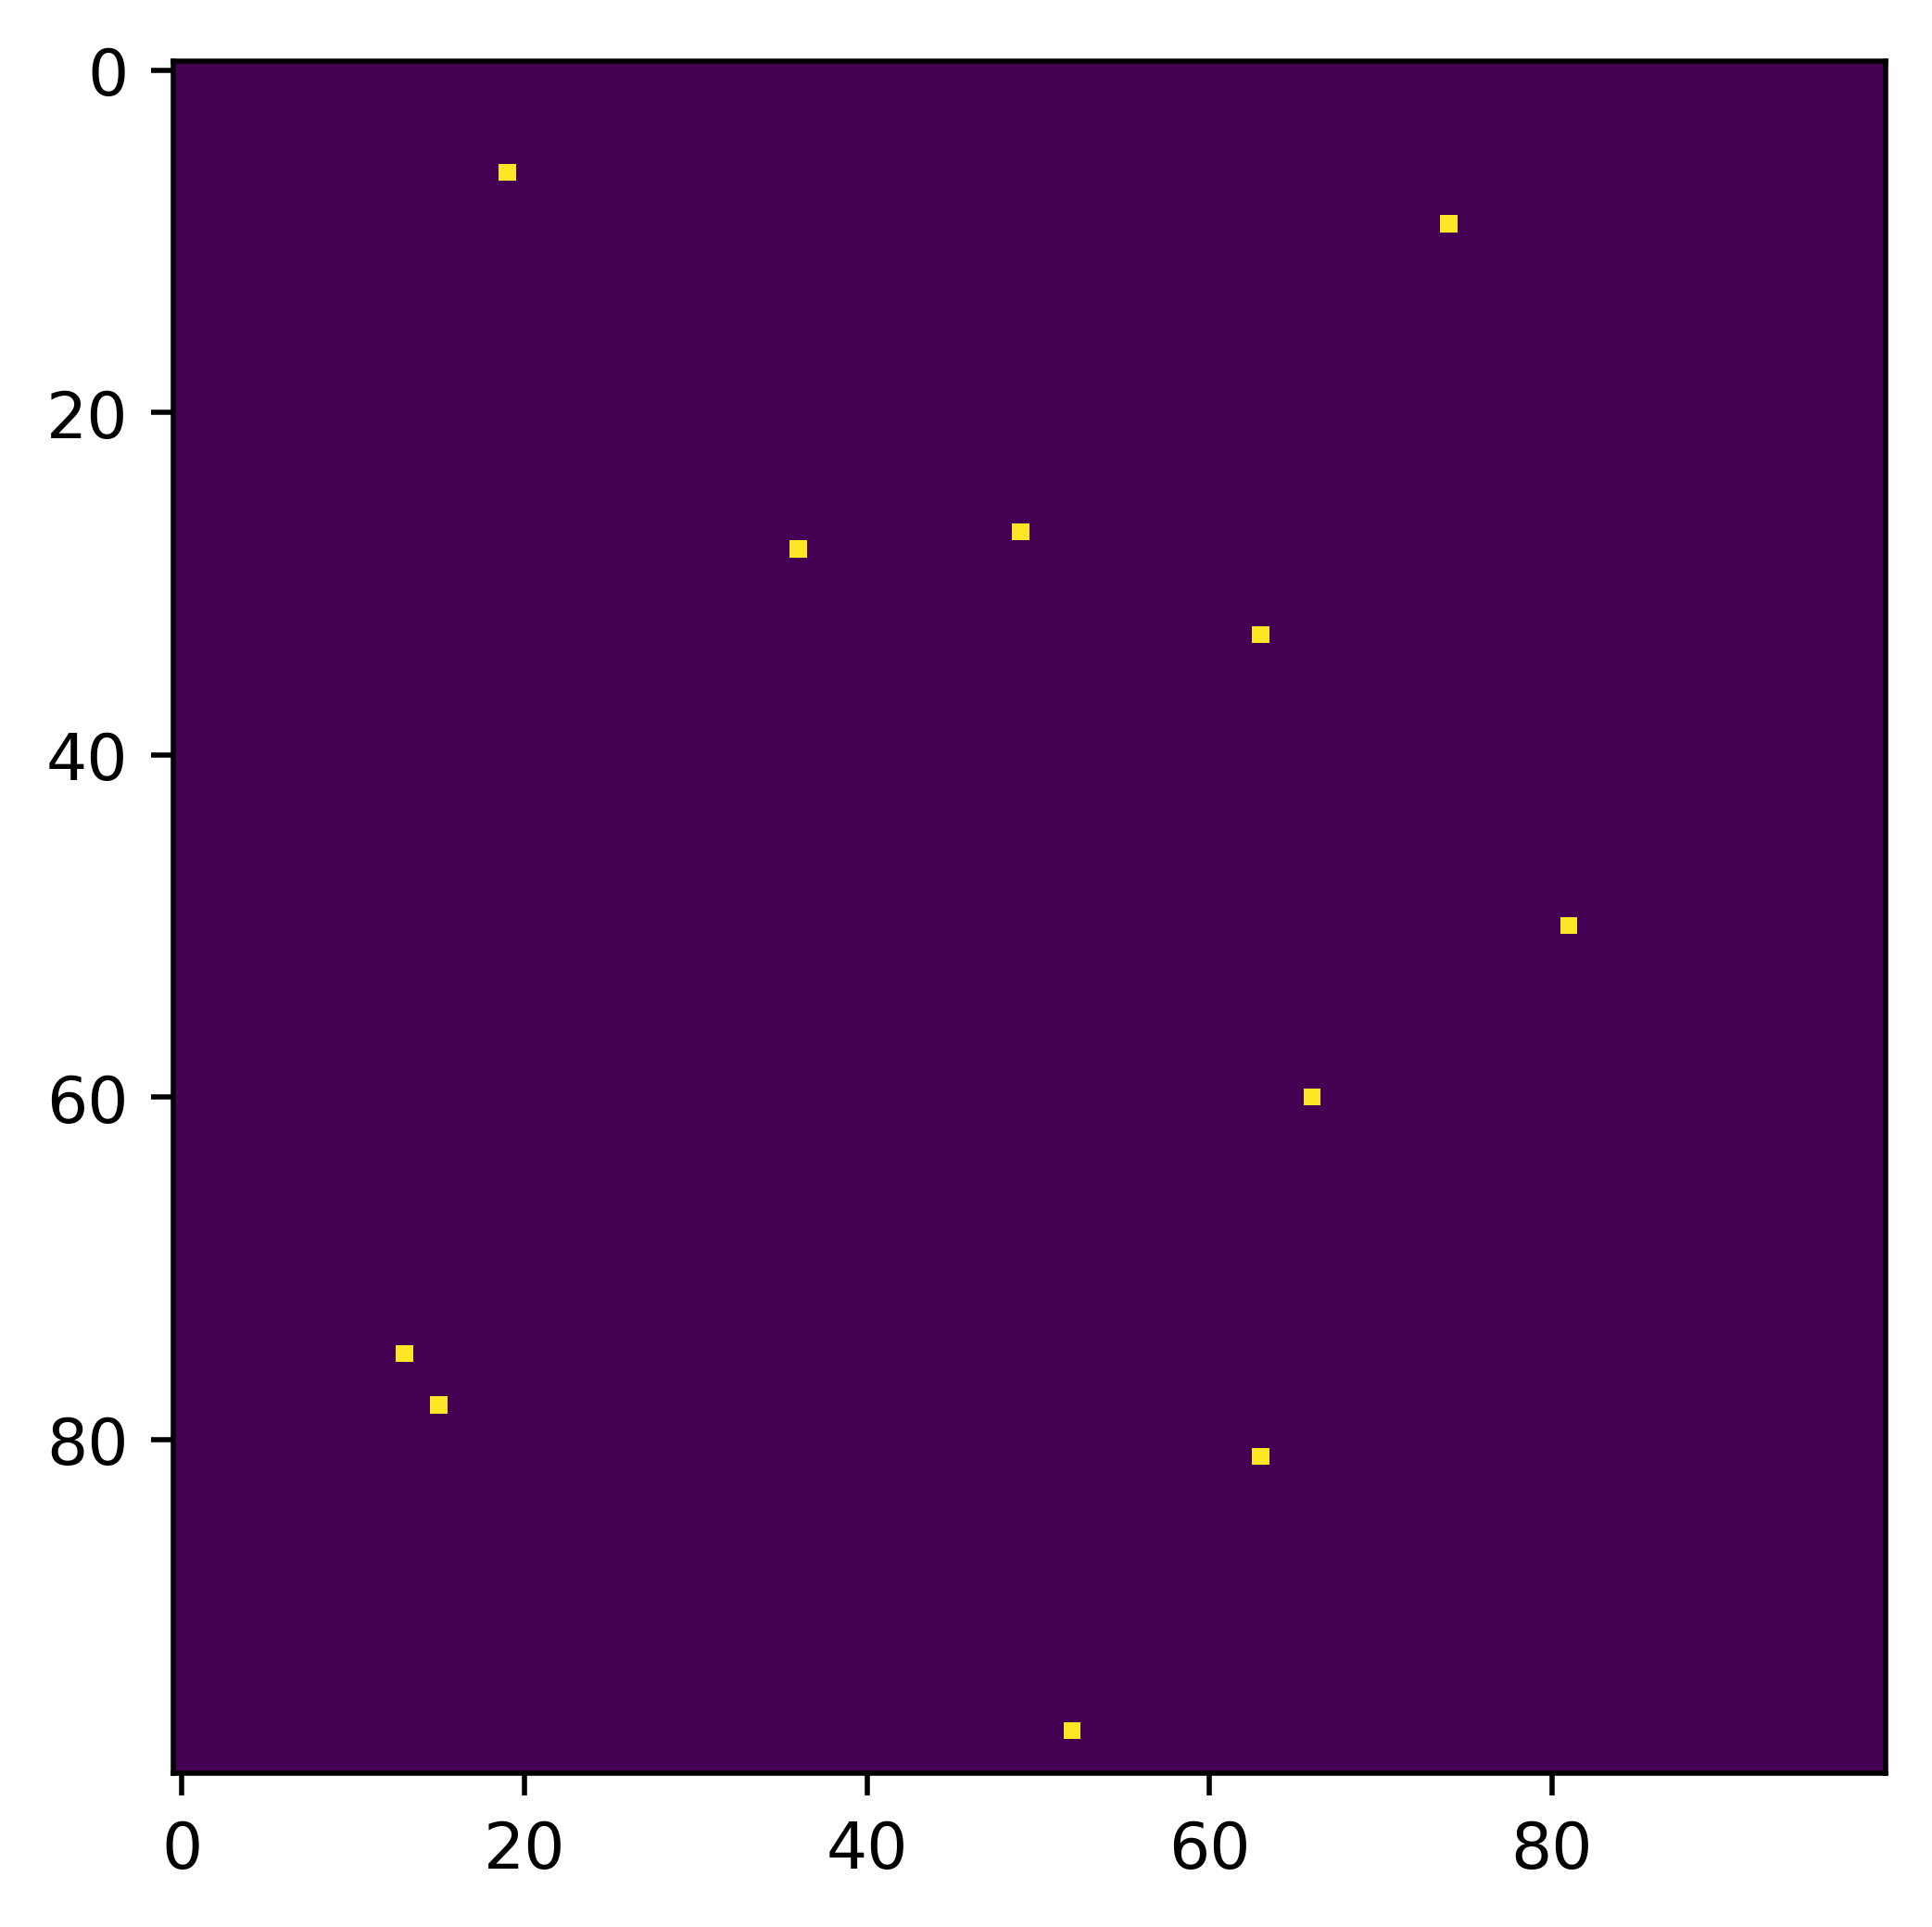

In [52]:
# Create Target (Ground Truth Image)

np.random.seed(0)
image_size = 100
emitter_density = 0.001
pixel_size = 0.1e-6
image = np.random.choice([0,1], size=(image_size,image_size), p=[1-emitter_density, emitter_density])

plt.imshow(image)

(100, 100)

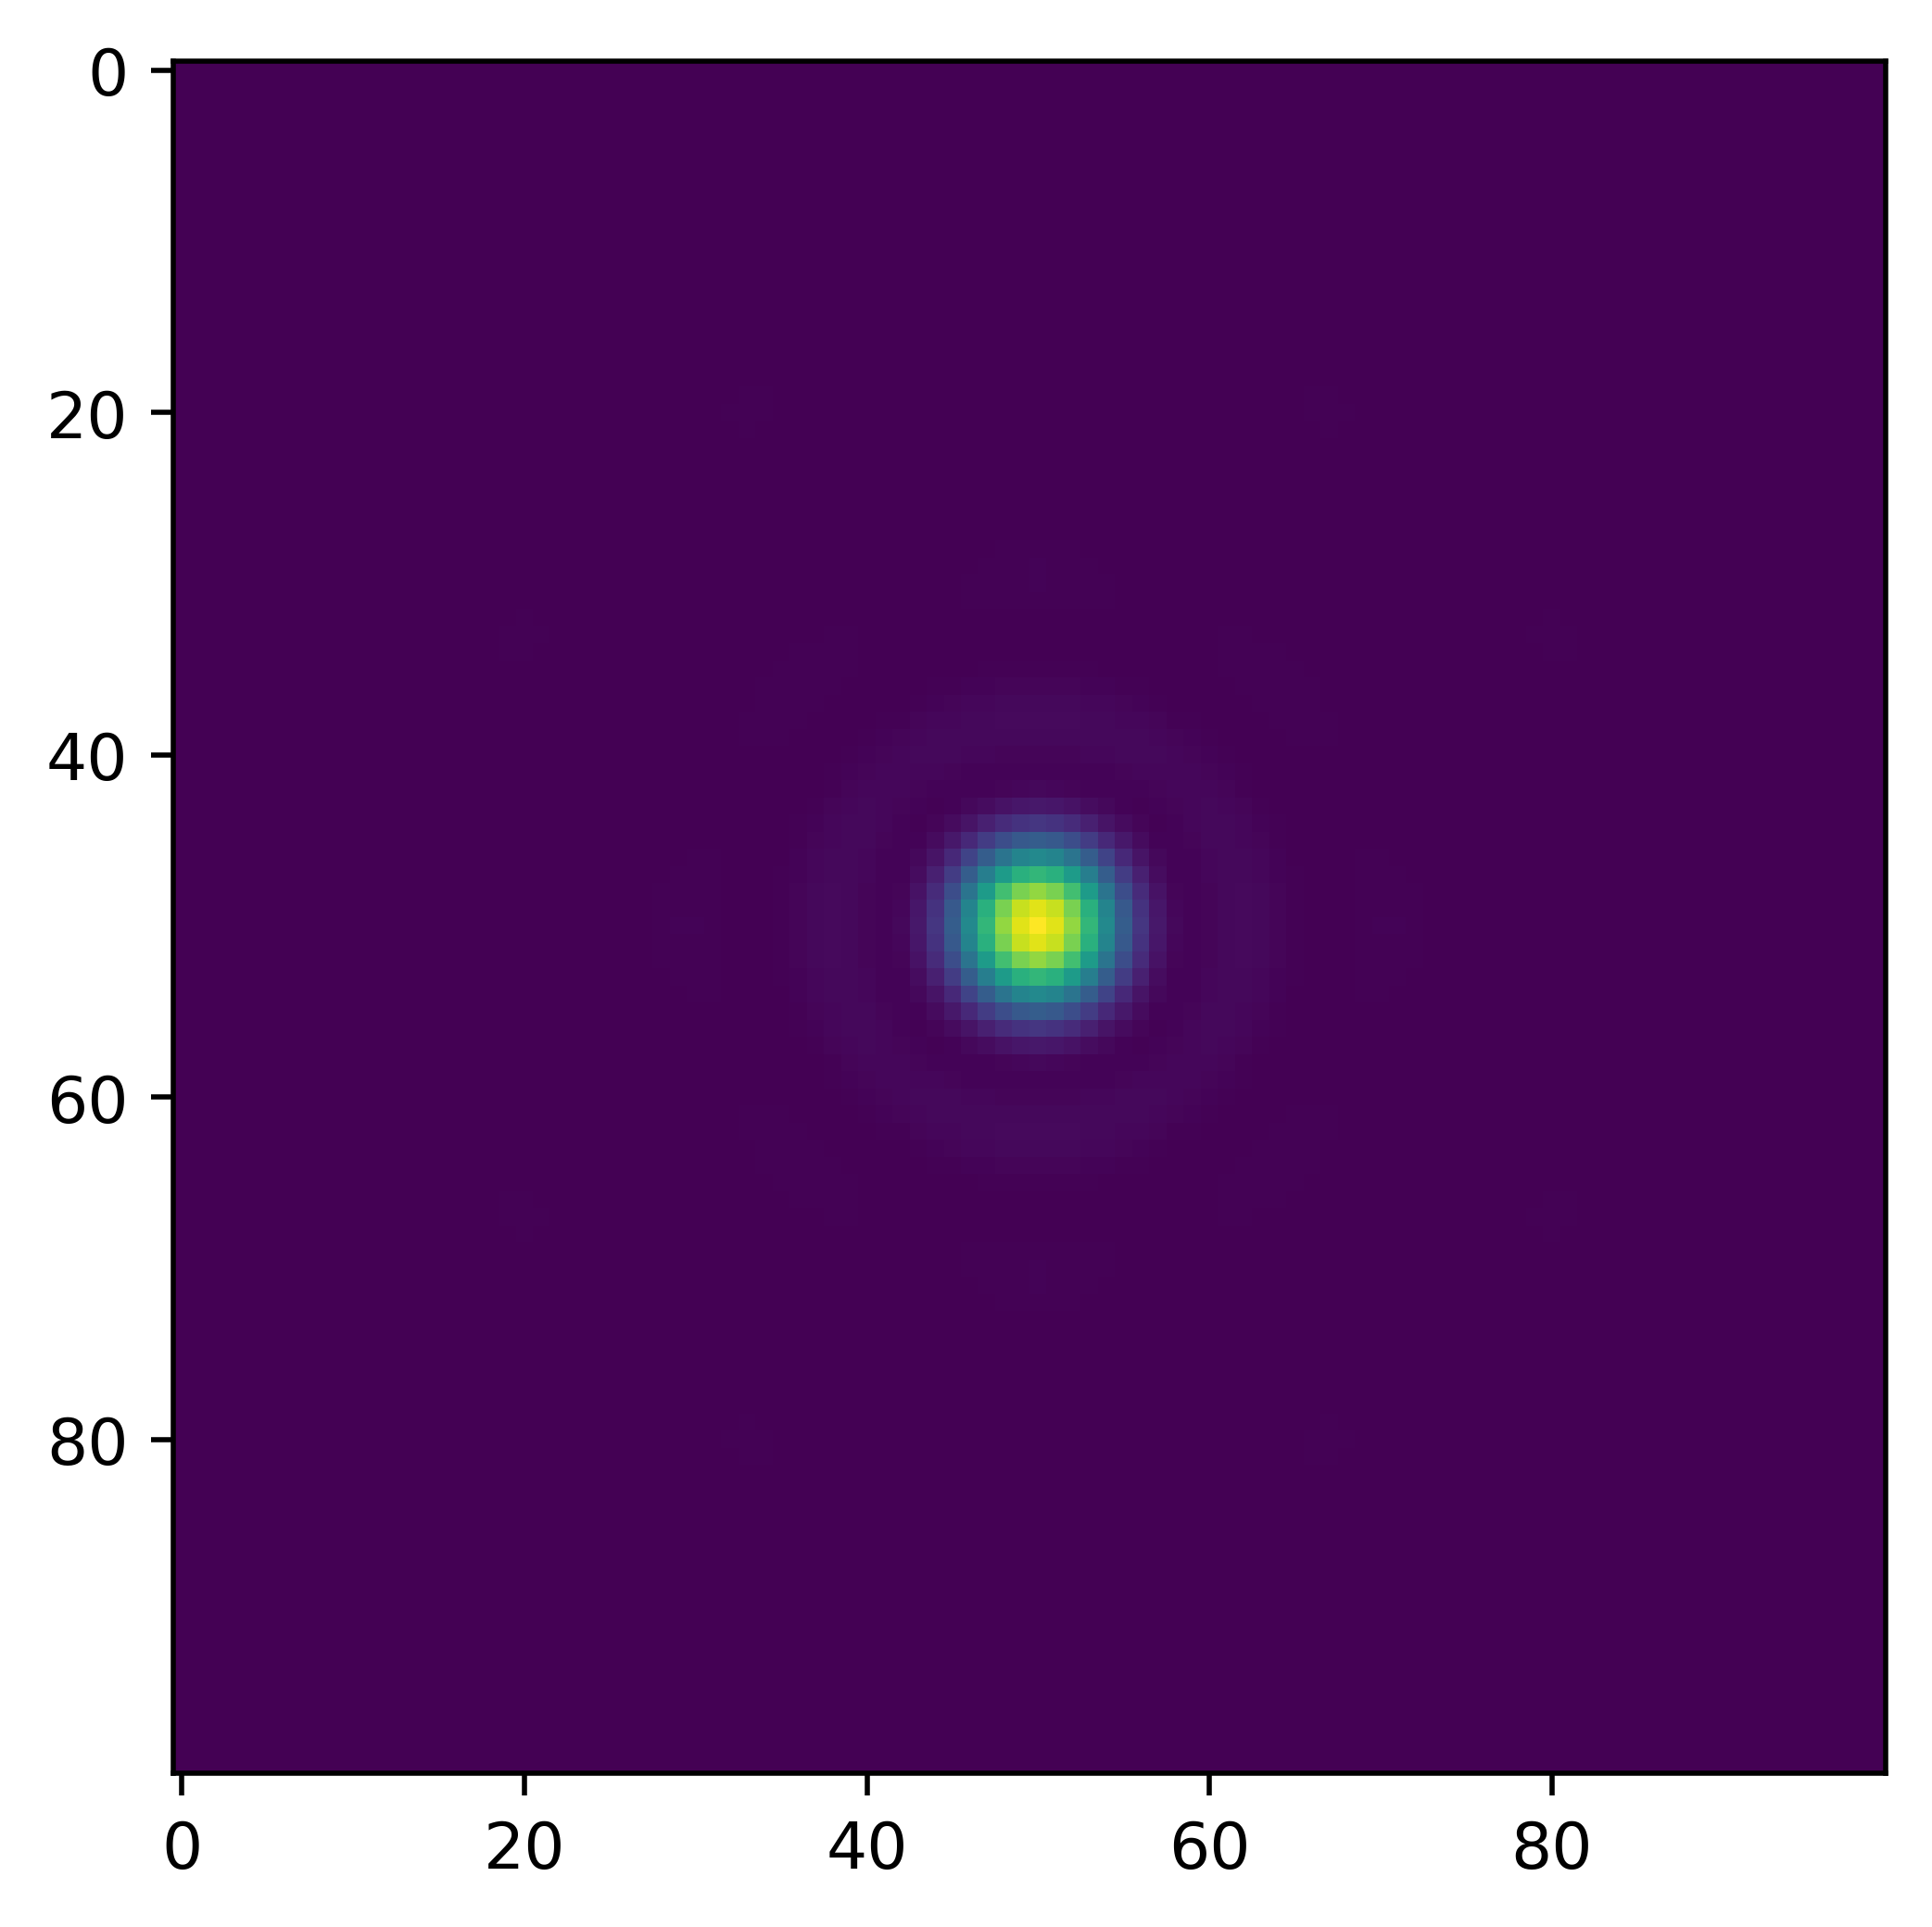

In [62]:
# Create PSF

device = torch.device('cpu')
scope = Microscope(dim=100, NA=0.5, mag=30, wavelength=500e-9, pixel_size=2e-6, device=device)
psf = scope.get_psf(defocus_length=0.5e-6)

psf = psf.numpy()

plt.imshow(psf)

psf.shape

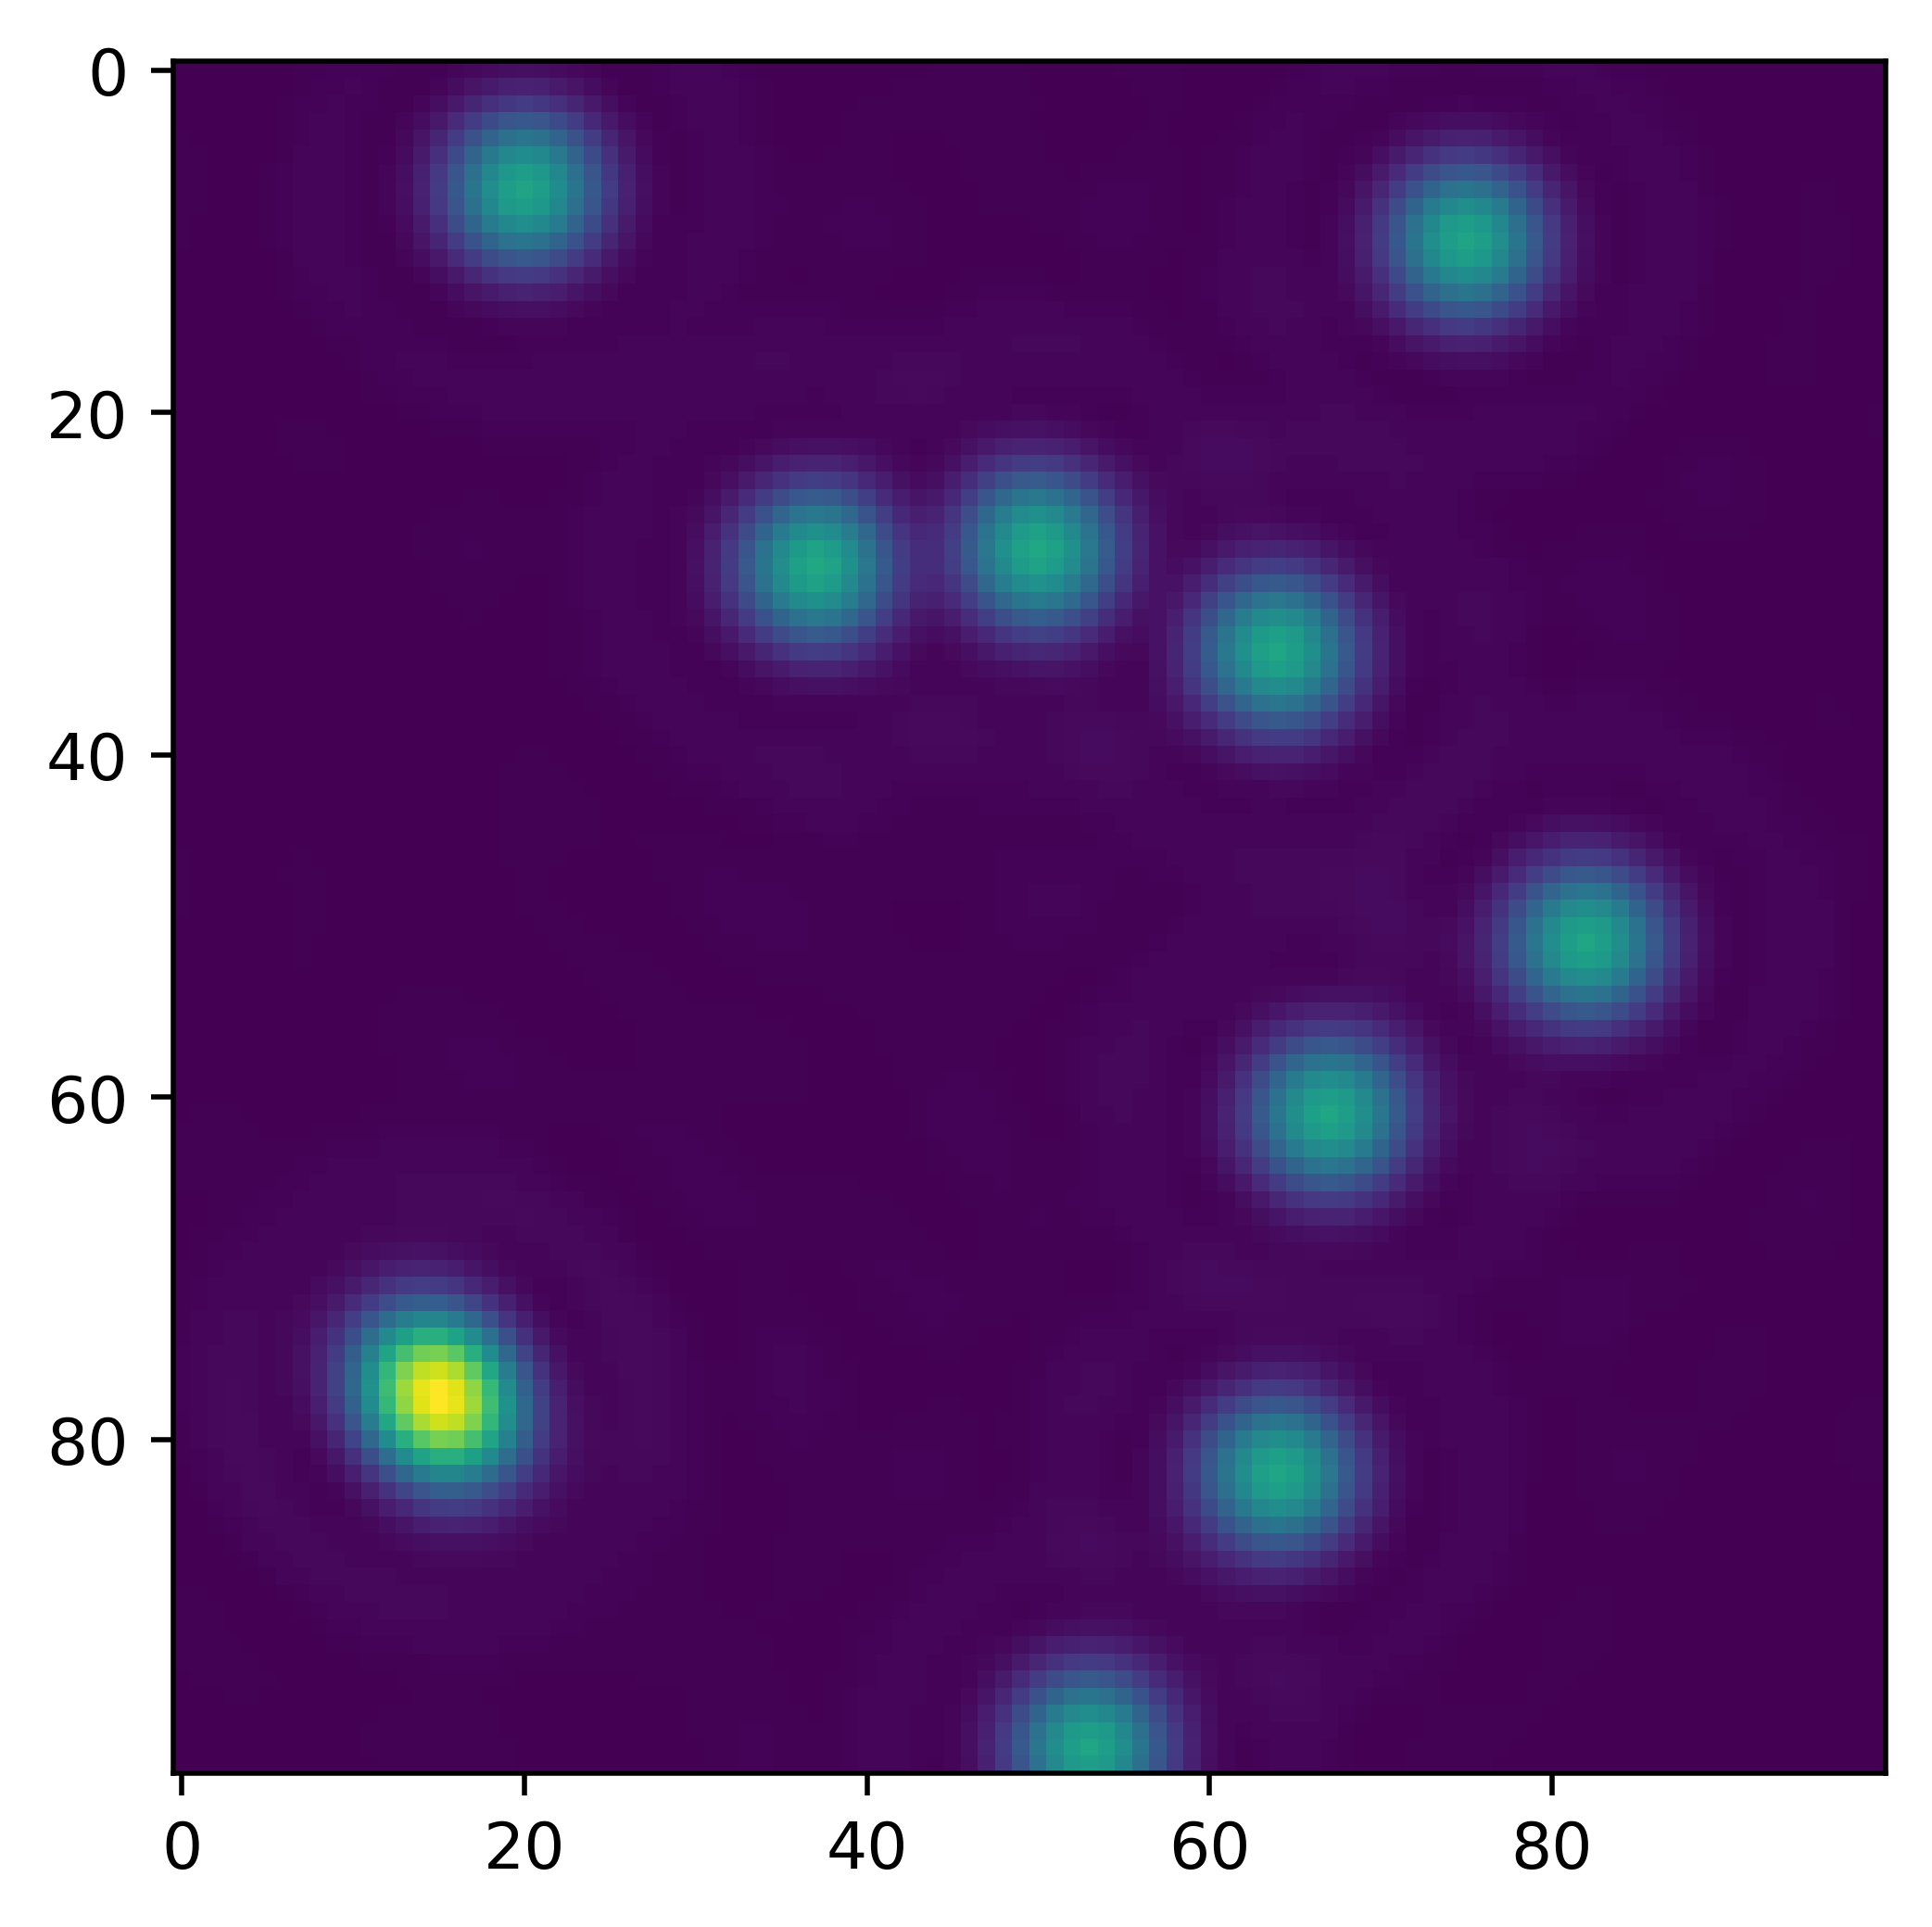

In [54]:
# Create Measurement from Convolution with PSF

blurred_image = conv2(image, psf, 'same')

plt.imshow(blurred_image)

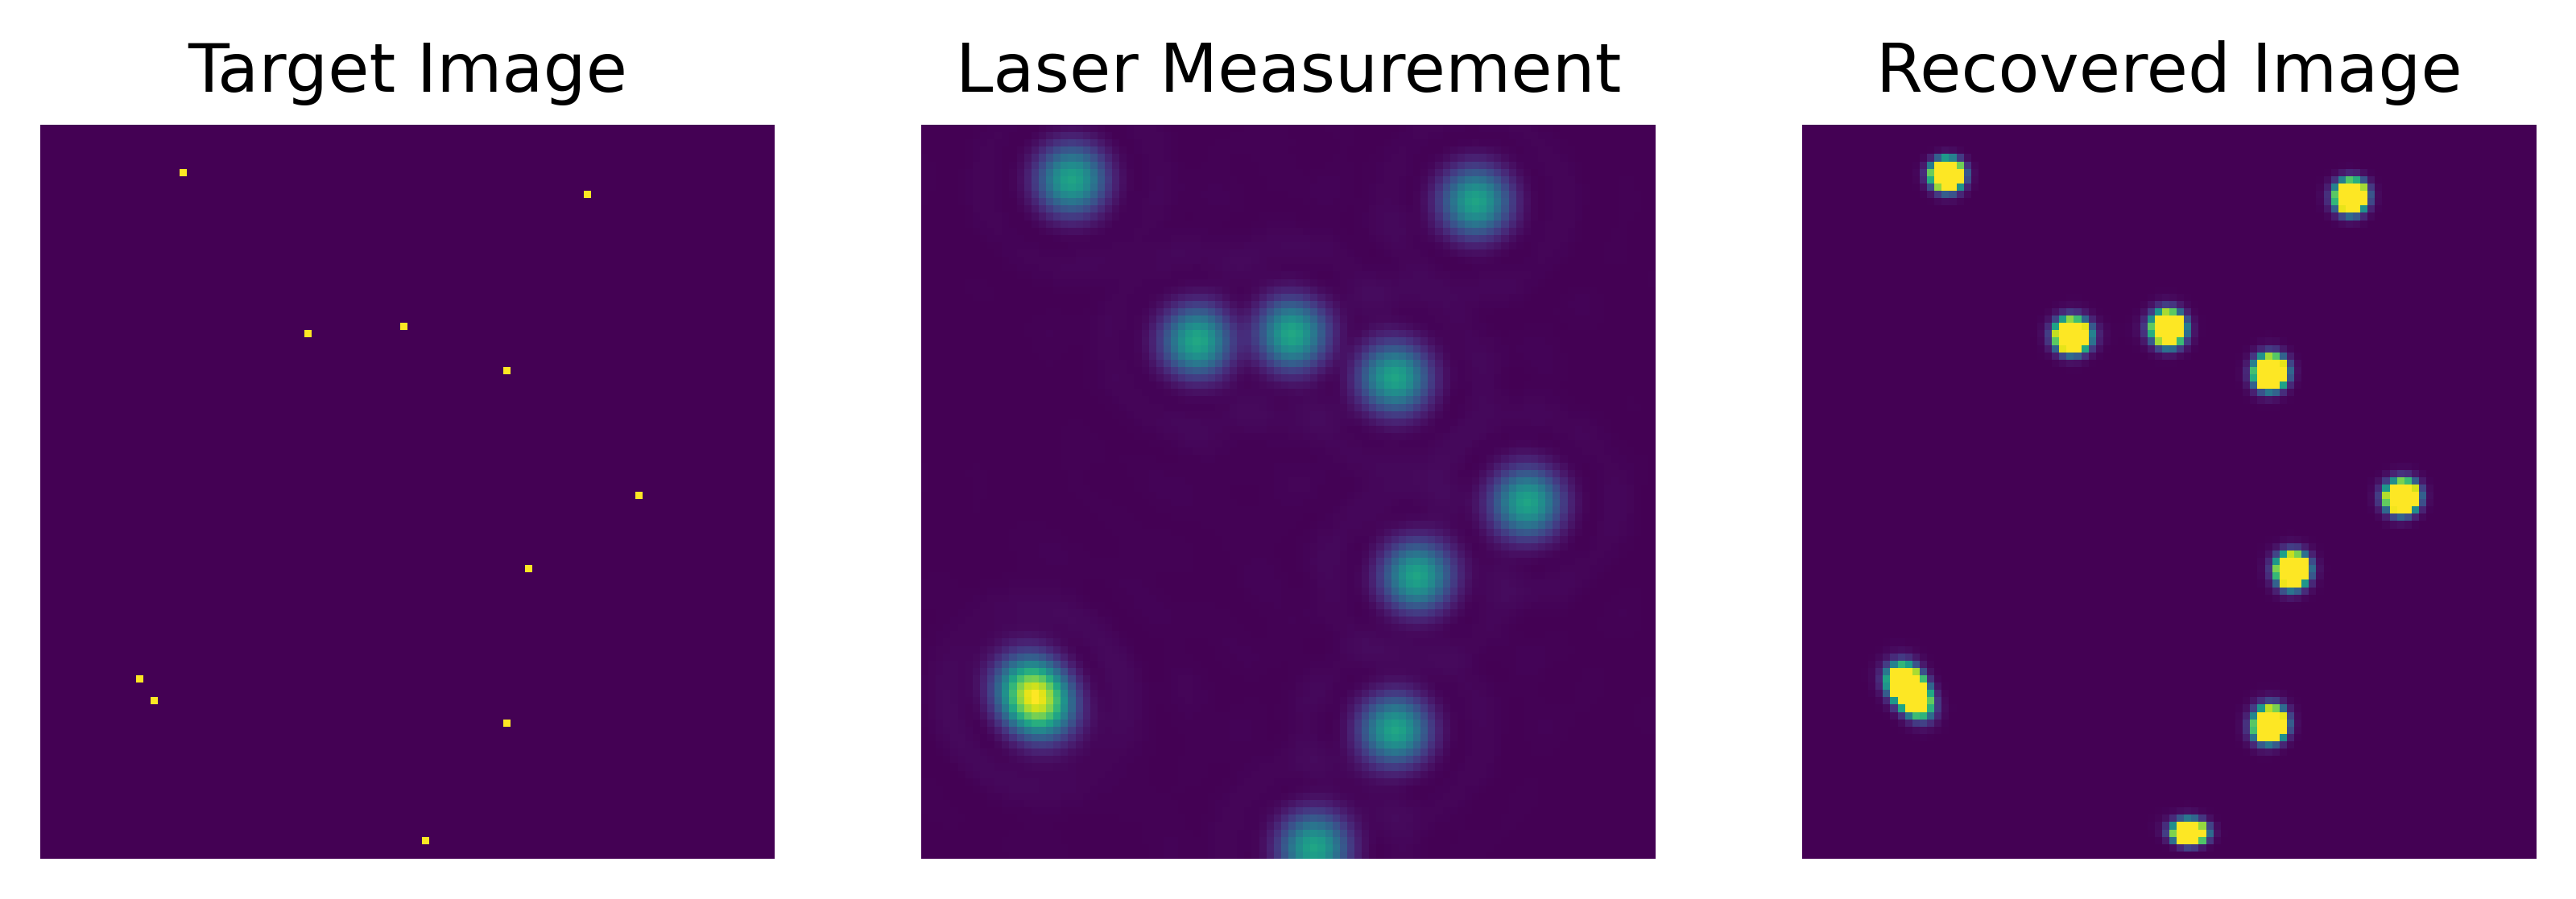

In [55]:
# Deconvolution

recovered_image = restoration.richardson_lucy(blurred_image, psf, num_iter=30)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))

for a in (ax[0], ax[1], ax[2]):
    a.axis('off')

ax[0].imshow(image)
ax[0].set_title('Target Image')

ax[1].imshow(blurred_image)
ax[1].set_title('Laser Measurement')

ax[2].imshow(recovered_image, vmin=blurred_image.min(), vmax=blurred_image.max())
ax[2].set_title('Recovered Image')

#fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
plt.show()

Iter: 0 --- MSE: 9.530308209873764 --- New defocus: 0.09530308209873764
Iter: 1 --- MSE: 9.528351799264712 --- New defocus: 0.19058660009138476
Iter: 2 --- MSE: 9.522613570808383 --- New defocus: 0.2858127357994686
Iter: 3 --- MSE: 9.513523759237936 --- New defocus: 0.38094797339184794
Iter: 4 --- MSE: 9.501938939621482 --- New defocus: 0.47596736278806273
Iter: 5 --- MSE: 9.489240448814675 --- New defocus: 0.5708597672762095
Iter: 6 --- MSE: 9.477171847043179 --- New defocus: 0.6656314857466412
Iter: 7 --- MSE: 9.46748424163601 --- New defocus: 0.7603063281630014
Iter: 8 --- MSE: 9.461644803391321 --- New defocus: 0.8549227761969146
Iter: 9 --- MSE: 9.460723601472948 --- New defocus: 0.9495300122116441
Breaking --- MSE: 9.460723601472948


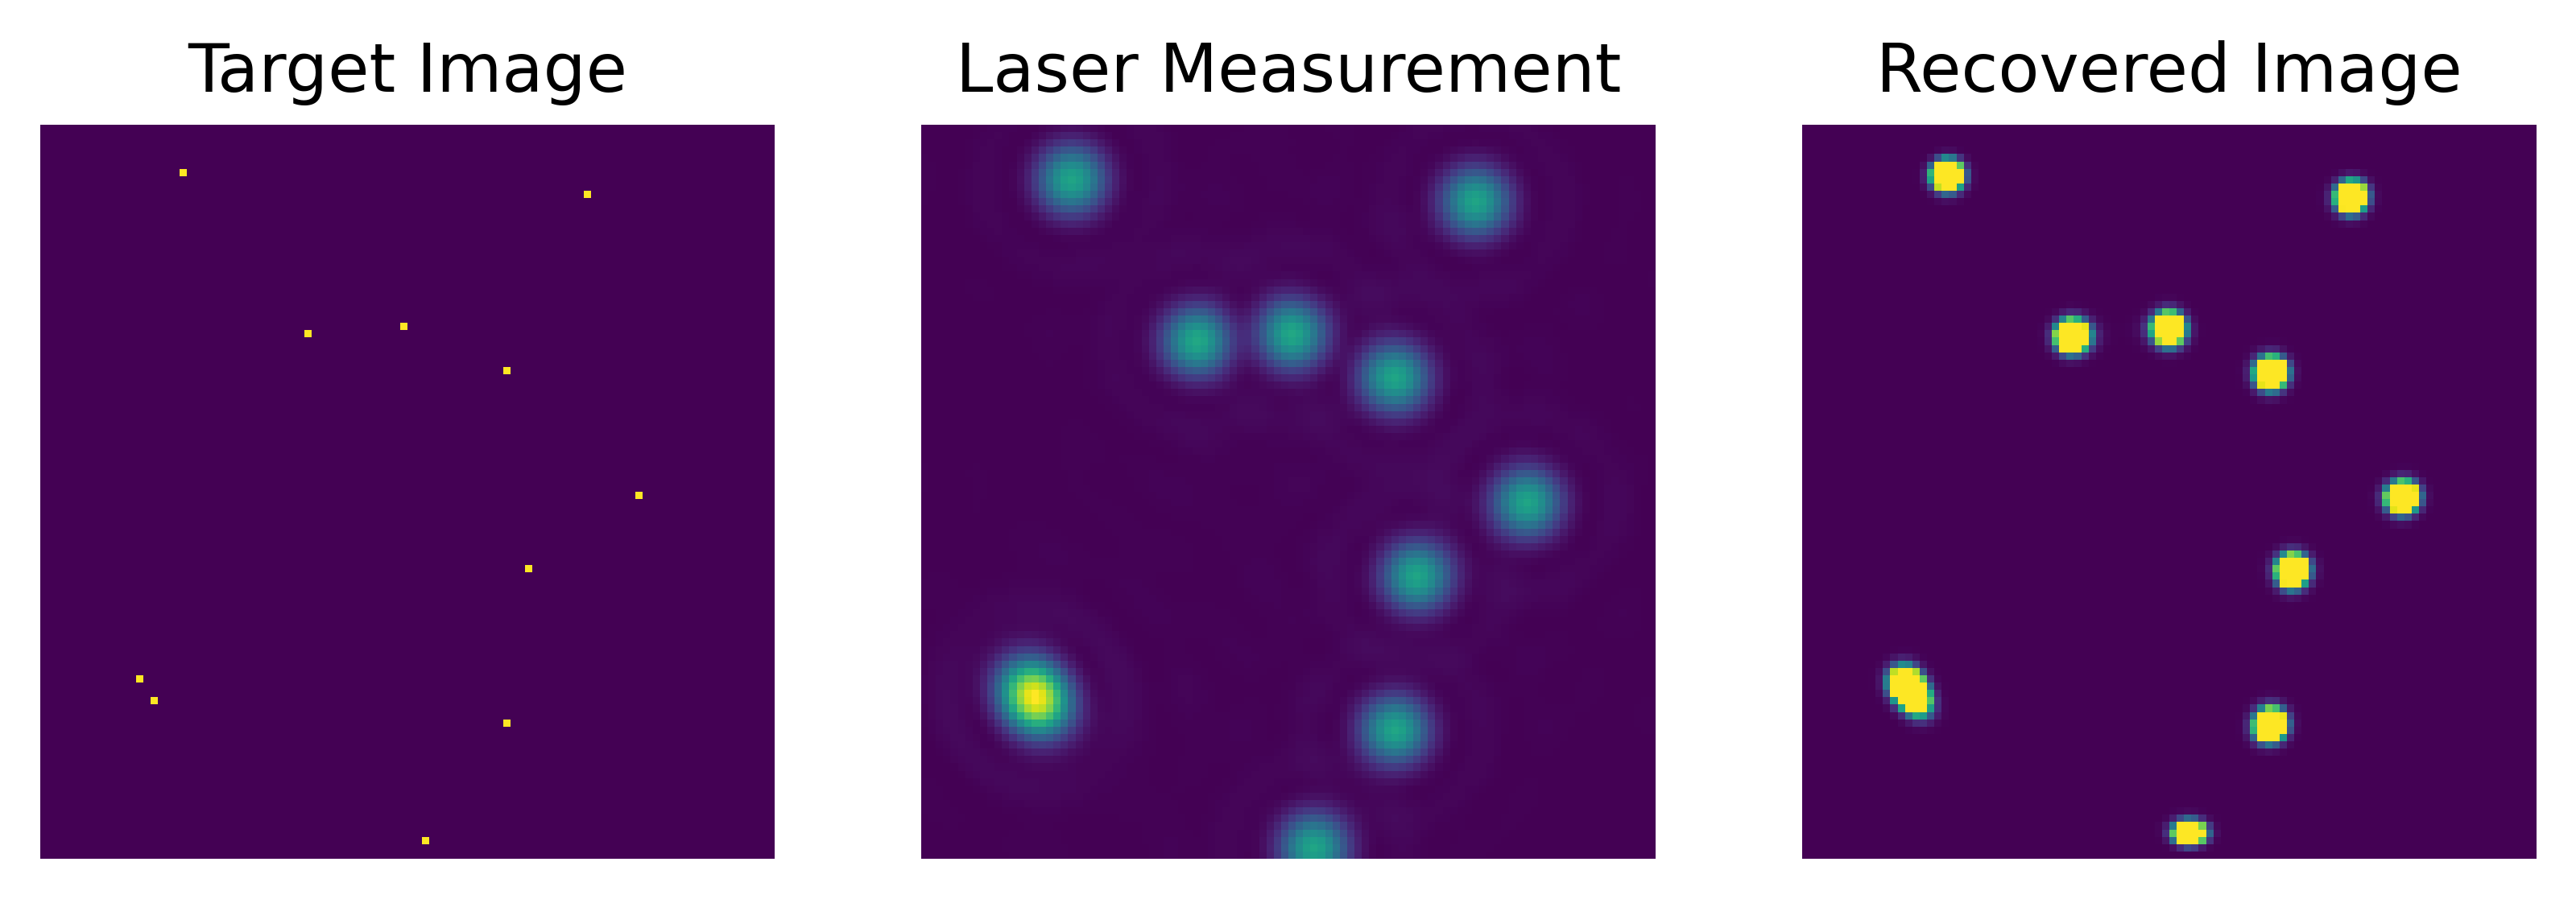

In [56]:
# Deconvolution with Gradient Descent

device = torch.device('cpu')
scope = Microscope(dim=100, NA=0.5, mag=30, wavelength=500e-9, pixel_size=2e-6, device=device)

psf_defocus = 0
mse = 10000
learning_rate=0.01
niter=30
prev_recovered_image = recovered_image

for i in range(niter):
        psf_var = scope.get_psf(defocus_length=psf_defocus*1e-6)
        psf_var = psf_var.numpy()
        prev_recovered_image = recovered_image
        recovered_image = restoration.richardson_lucy(blurred_image, psf_var, num_iter=30)
        #mse = np.sum((image-recovered_image) ** 2)
        if mse < np.sum((image-recovered_image) ** 2):
            # new MSE is larger than before - use previous recovered image
            recovered_image = prev_recovered_image
            print('Breaking --- MSE: ' + str(mse))
            break
        else:
            mse = np.sum((image-recovered_image) ** 2)

        psf_defocus = psf_defocus + (mse * learning_rate)
        print('Iter: ' + str(i) + ' --- MSE: ' + str(mse) + ' --- New defocus: ' + str(psf_defocus))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))

for a in (ax[0], ax[1], ax[2]):
    a.axis('off')

ax[0].imshow(image)
ax[0].set_title('Target Image')

ax[1].imshow(blurred_image)
ax[1].set_title('Laser Measurement')

ax[2].imshow(recovered_image, vmin=blurred_image.min(), vmax=blurred_image.max())
ax[2].set_title('Recovered Image')

#fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
plt.show()

(100, 100)

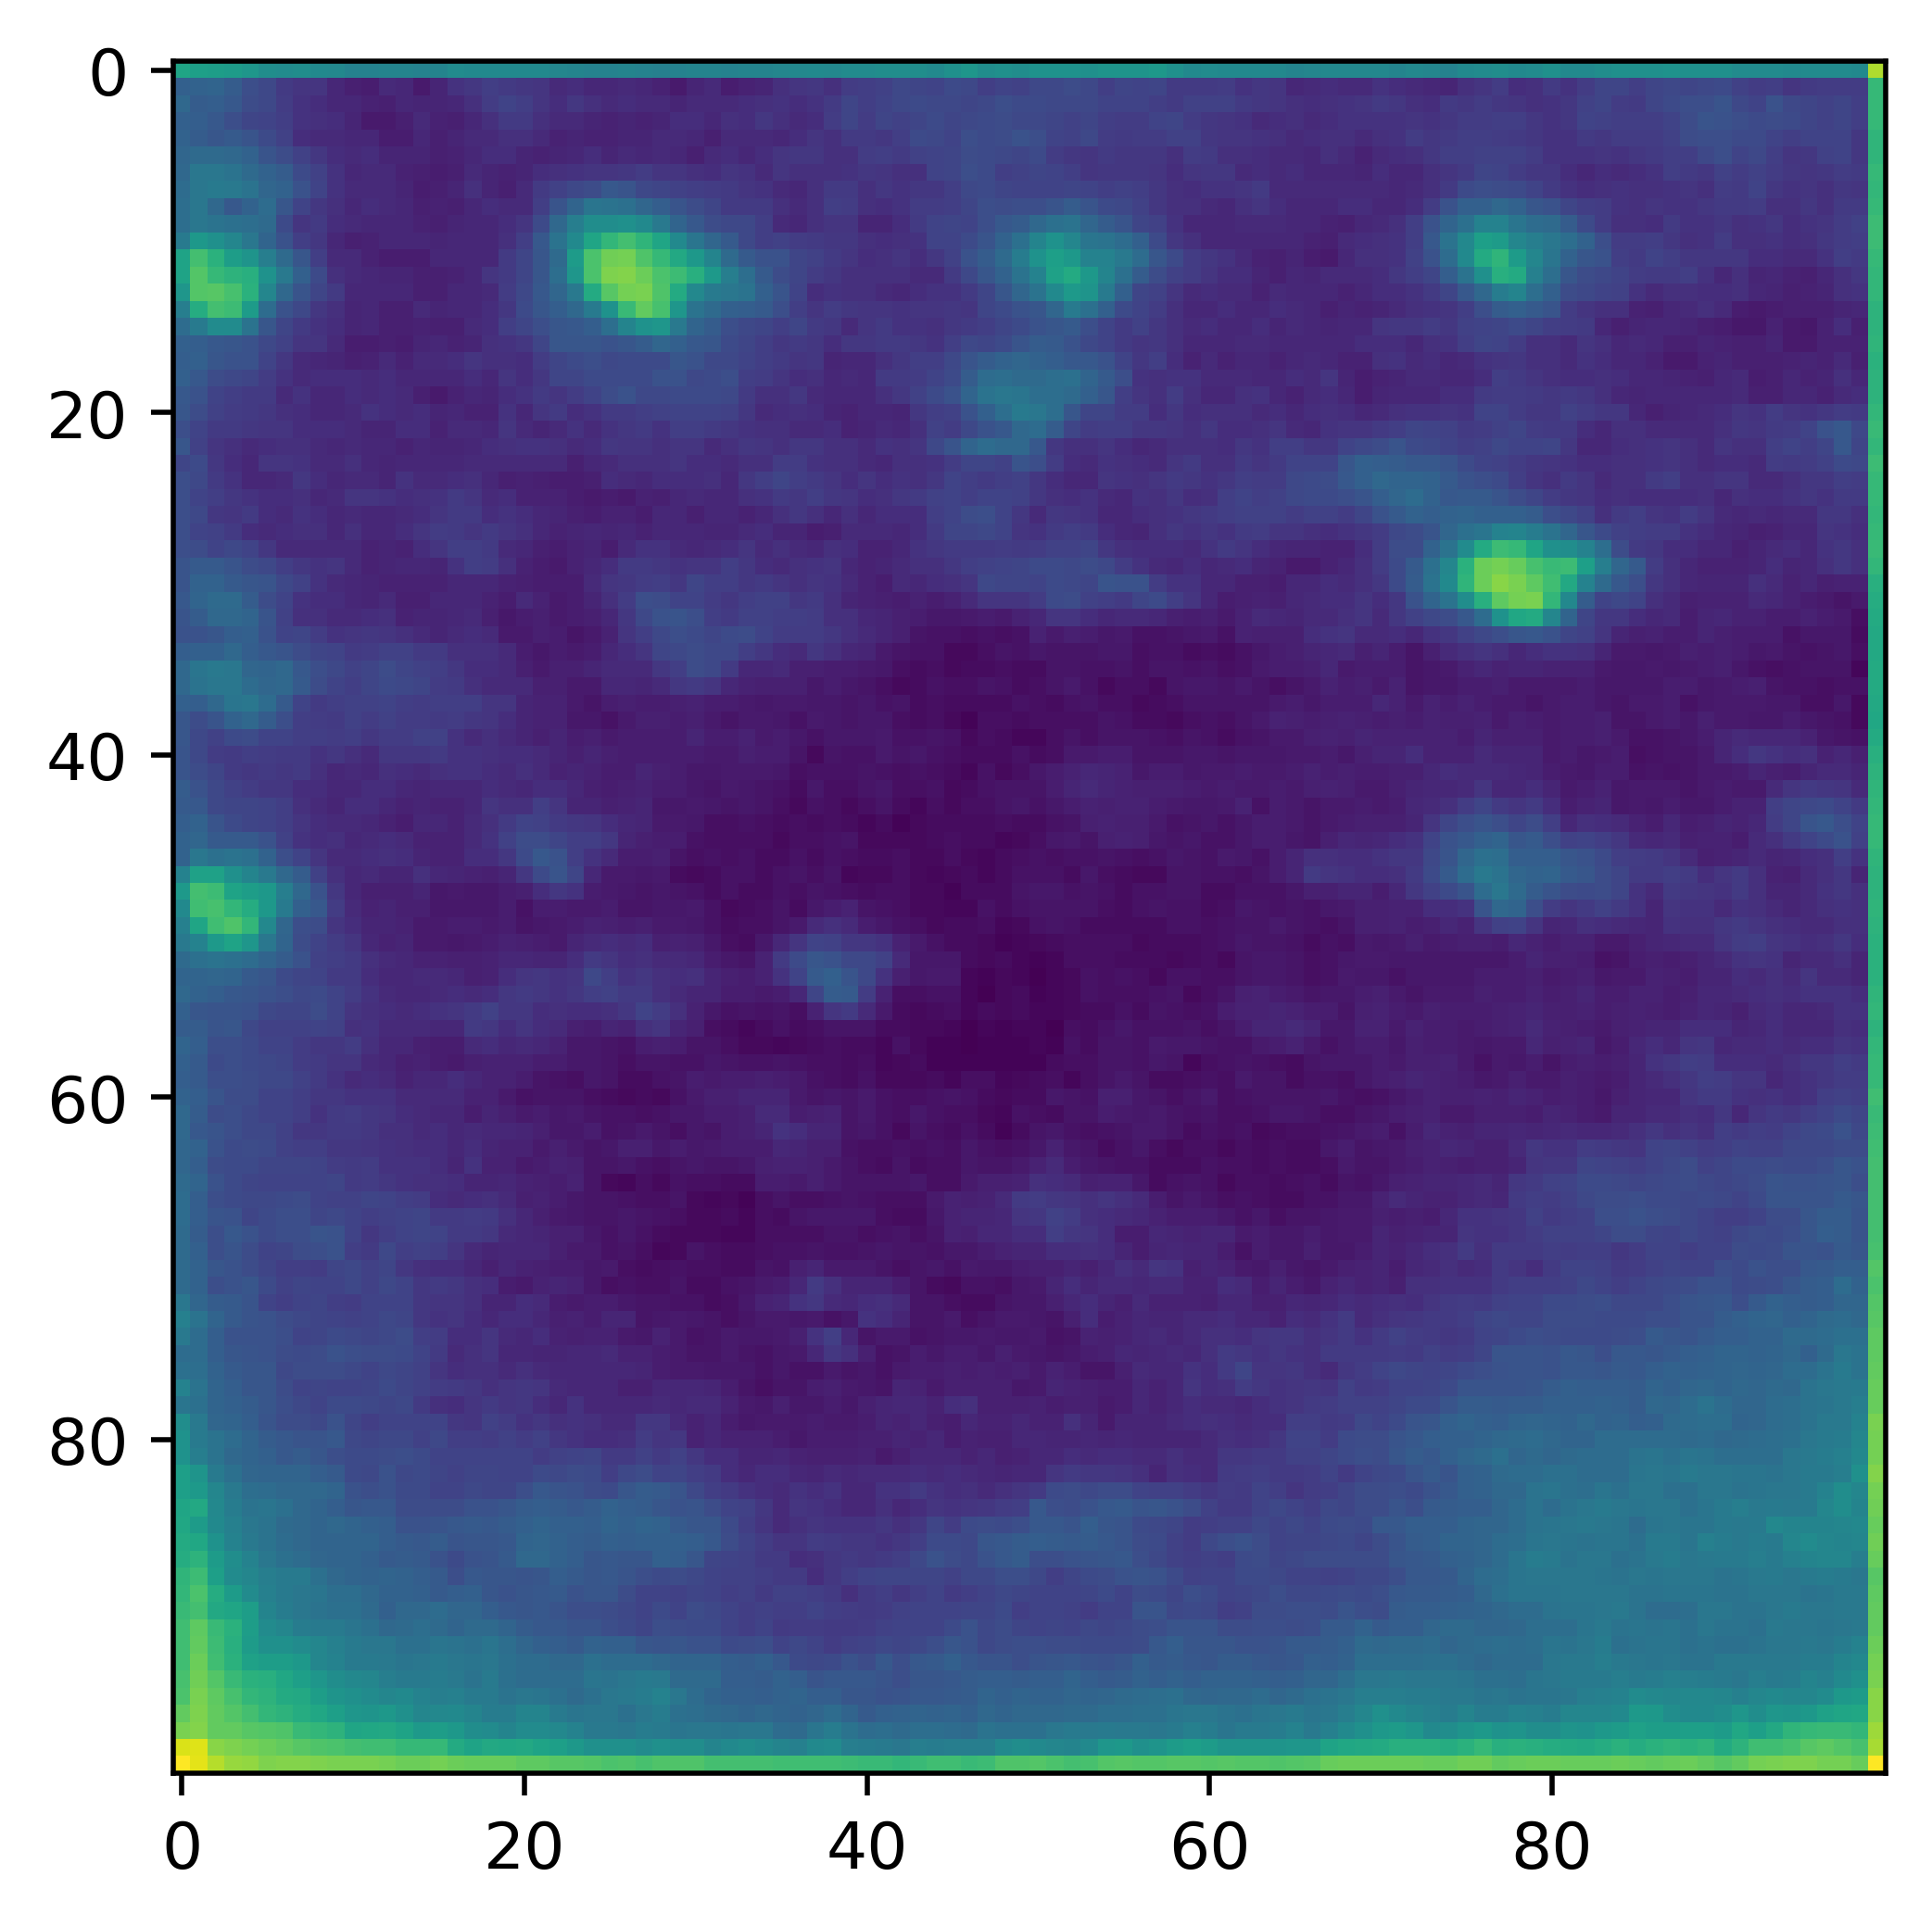

In [64]:
# Test with Simulation Image

from PIL import Image
sim_image_open = Image.open('sim_image.png').resize((100,100))

sim_image = np.array(sim_image_open.convert("L"))
sim_image

plt.imshow(sim_image)

sim_image.shape

Iter: 0 --- MSE: 9717.21014174926 --- New defocus: 97.1721014174926
Iter: 1 --- MSE: 1416.8165790840364 --- New defocus: 111.34026720833296
Breaking --- MSE: 1416.8165790840364
Iter: 2 --- MSE: 1416.8165790840364 --- New defocus: 125.50843299917332
Breaking --- MSE: 1416.8165790840364
Iter: 3 --- MSE: 1416.8165790840364 --- New defocus: 139.67659879001368
Breaking --- MSE: 1416.8165790840364
Iter: 4 --- MSE: 1416.8165790840364 --- New defocus: 153.84476458085405
Breaking --- MSE: 1416.8165790840364
Iter: 5 --- MSE: 1416.8165790840364 --- New defocus: 168.0129303716944
Breaking --- MSE: 1416.8165790840364
Iter: 6 --- MSE: 1416.8165790840364 --- New defocus: 182.18109616253477
Breaking --- MSE: 1416.8165790840364
Iter: 7 --- MSE: 1416.8165790840364 --- New defocus: 196.34926195337513
Iter: 8 --- MSE: 1323.6720580676642 --- New defocus: 209.58598253405177
Breaking --- MSE: 1323.6720580676642
Iter: 9 --- MSE: 1323.6720580676642 --- New defocus: 222.8227031147284
Breaking --- MSE: 1323.6720

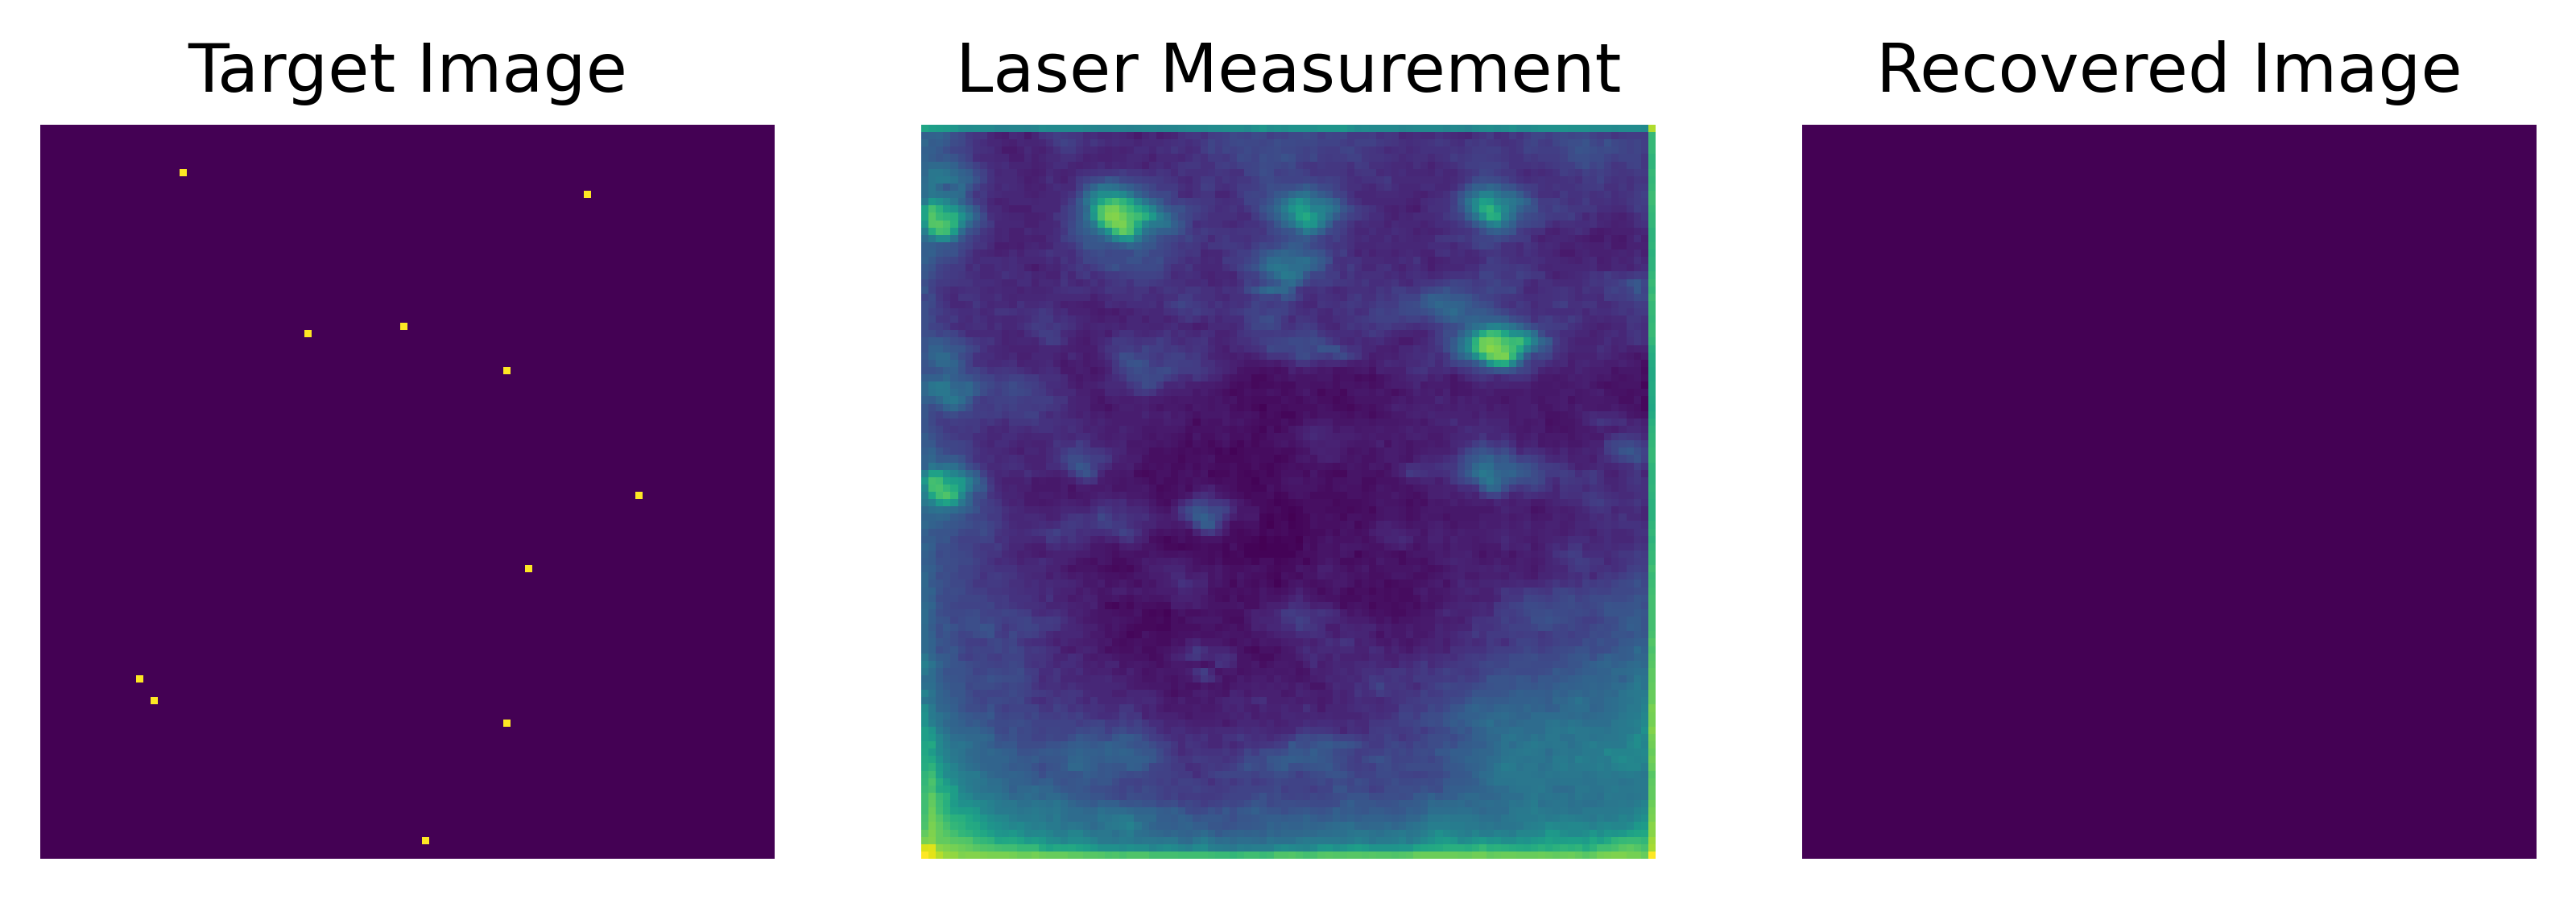

In [68]:
# Deconvolution with Gradient Descent

device = torch.device('cpu')
scope = Microscope(dim=100, NA=0.5, mag=30, wavelength=500e-9, pixel_size=2e-6, device=device)

psf_defocus = 0
mse = 10000
learning_rate=0.01
niter=30
prev_recovered_image = recovered_image

psf_var = scope.get_psf(defocus_length=psf_defocus*1e-6)
psf_var = psf_var.numpy()
prev_recovered_image = recovered_image
recovered_image = restoration.richardson_lucy(sim_image, psf_var, num_iter=30)

for i in range(niter):
        psf_var = scope.get_psf(defocus_length=psf_defocus*1e-6)
        psf_var = psf_var.numpy()
        prev_recovered_image = recovered_image
        recovered_image = restoration.richardson_lucy(sim_image, psf_var, num_iter=30)
        #mse = np.sum((image-recovered_image) ** 2)
        if mse < np.sum((image-recovered_image) ** 2):
            # new MSE is larger than before - use previous recovered image
            recovered_image = prev_recovered_image
            print('Breaking --- MSE: ' + str(mse))
            #break
        else:
            mse = np.sum((image-recovered_image) ** 2)

        psf_defocus = psf_defocus + (mse * learning_rate)
        print('Iter: ' + str(i) + ' --- MSE: ' + str(mse) + ' --- New defocus: ' + str(psf_defocus))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))

for a in (ax[0], ax[1], ax[2]):
    a.axis('off')

ax[0].imshow(image)
ax[0].set_title('Target Image')

ax[1].imshow(sim_image)
ax[1].set_title('Laser Measurement')

ax[2].imshow(recovered_image, vmin=sim_image.min(), vmax=sim_image.max())
ax[2].set_title('Recovered Image')

#fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
plt.show()